In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,mean_squared_log_error,explained_variance_score,r2_score

#borough,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,commercial,residencial,mixed,# of bus_stop,# of subway_station,# of FELONY,# of VIOLATION,# of MISDEMEANOR,total # of poi,poi type 1,poi type 2,poi type 3,poi type 4,poi type 5,poi type 6,poi type 7,poi type 8,poi type 9,poi type 10,poi type 11,poi type 12,poi type 13,# of roads,total width of raods

raw_df = pd.read_csv("dataset/cat.csv",names=['type','borough','land_area','gross_area','year','price','numBuses','numSubways','numFelonies','numViolations','numMisdemeanors','totalPoi','poi1','poi2','poi3','poi4','poi5','poi6','poi7','poi8','poi9','poi10','poi11','poi12','poi13','numRoads','roadWidth'],skiprows=1,index_col=False) 
raw_df['type'] = pd.Categorical(raw_df['type'],[0,1,2])
raw_df['borough'] = pd.Categorical(raw_df['borough'],[1,2,3,4,5])
train_x, test_x, train_y, test_y = train_test_split(raw_df.loc[:, raw_df.columns != 'price'],raw_df['price'],test_size=.33)

In [18]:
%%time
## PCA 

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# Get feature matrix from pickled files to create linear regression model
df = pd.read_excel('dataset/feature_matrix_1200m_2.xlsx')

df = df[df.values[:,32]<1.46e6]
print(df.shape)
#df.as_matrix()
X_raw = df.values[:, :31]			# Matrix of shape[n_samples, n_features] (32 features)
np.random.seed(0)
train_x, test_x, y_train, y_test = train_test_split(df.values[:, :31],df.values[:,32],test_size=.20)

(49020, 33)


In [19]:
# SCALE DATA 
z_scaler = StandardScaler()
z_scaler.fit(train_x)
scaled_train_x = z_scaler.transform(train_x)
scaled_test_x = z_scaler.transform(test_x)

# PCA 
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(scaled_train_x)
PCA_x_train = pca.transform(train_x)
PCA_x_test = pca.transform(test_x)
#print("pca explained variance", pca.explained_variance_)
print("pca explained variance ratio", pca.explained_variance_ratio_)
#print("pca components", pca.components_)
print("shape", PCA_x_train.shape)

/home/nik/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


('pca explained variance ratio', array([0.27580661, 0.08307828, 0.06762462, 0.05640855, 0.04740012,
       0.04176539, 0.04002197, 0.03458605, 0.03278377, 0.03045786,
       0.02941309, 0.02635603, 0.02429375, 0.02341507, 0.02166128,
       0.02134402, 0.0196682 , 0.01900456, 0.01819425, 0.01692547,
       0.01450322, 0.0134224 ]))
('shape', (39216, 22))


In [20]:
PCA_x_train = pd.DataFrame(PCA_x_train)
PCA_x_train.to_pickle('dataset/PCA_x_train.pkl')
pickle.dump(y_train,open('dataset/y_train.pkl','wb'))
PCA_x_test = pd.DataFrame(PCA_x_test)
PCA_x_test.to_pickle('dataset/PCA_x_test.pkl')
pickle.dump(y_test,open('dataset/y_test.pkl','wb'))

CPU times: user 14 s, sys: 484 ms, total: 14.5 s
Wall time: 15 s


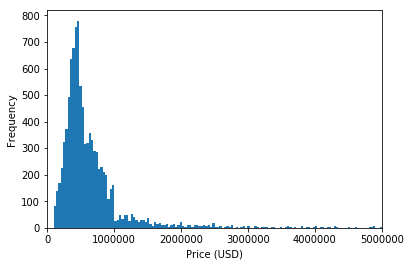

In [21]:
%%time
%matplotlib inline
plt.xlim(0,.5e7)
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.hist(raw_df['price'].sample(10000),bins='auto')

In [22]:
#unique, counts = np.unique(x['borough'], return_counts=True)
#dict(zip(unique, counts))
baseline = np.zeros(raw_df['price'].shape) + np.median(raw_df['price'])
print("Baseline MAE: {}".format(mean_absolute_error(raw_df['price'],baseline)))
print("Baseline MSE: {}".format(mean_squared_error(raw_df['price'],baseline)))
print("Baseline median error: {}".format(median_absolute_error(raw_df['price'],baseline)))
print("Baseline mslog error: {}".format(mean_squared_log_error(raw_df['price'],baseline)))
print("Baseline variance score: {}".format(explained_variance_score(raw_df['price'],baseline)))
print("Baseline r^2 score: {}".format(r2_score(raw_df['price'],baseline)))

Baseline MAE: 801538.732415
Baseline MSE: 4.73061814968e+13
Baseline median error: 165000.0
Baseline mslog error: 0.590847155041
Baseline variance score: 0.0
Baseline r^2 score: -0.0094364505542


In [23]:
%%time
forest = RandomForestRegressor(128)
forest.fit(PCA_x_train,y_train)
yhat = forest.predict(PCA_x_test)
print("MAE: {}".format(mean_absolute_error(y_test,yhat)))
print("MSE: {}".format(mean_squared_error(y_test,yhat)))
print("median error: {}".format(median_absolute_error(y_test,yhat)))
print("mslog error: {}".format(mean_squared_log_error(y_test,yhat)))
print("variance score: {}".format(explained_variance_score(y_test,yhat)))
print("r^2 score: {}".format(r2_score(y_test,yhat)))

MAE: 27412.7201266
MSE: 2808941225.42
median error: 11156.3046875
mslog error: 0.0180018366622
variance score: 0.956670939244
r^2 score: 0.956665903345
CPU times: user 4min 58s, sys: 703 ms, total: 4min 59s
Wall time: 5min 3s


In [24]:
labels = ['b0','b1','b2','b3','b4','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','commercial','residencial','mixed','# of bus_stop','# of subway_station','# of FELONY','# of VIOLATION','# of MISDEMEANOR','total # of poi','poi type 1','poi type 2','poi type 3','poi type 4','poi type 5','poi type 6','poi type 7','poi type 8','poi type 9','poi type 10','poi type 11','poi type 12','poi type 13','# of roads','total width of raods']

indices = np.array(np.argsort(abs(np.array(pca.components_[0]))))
for l,i in list(zip(np.array(labels)[indices],np.array(pca.components_[0])[indices]))[::-1]:
	print("{}: {}".format(l,i))

total # of poi: 0.321685342588
# of MISDEMEANOR: 0.299094889067
# of VIOLATION: 0.296173648598
# of FELONY: 0.28959161082
poi type 1: 0.259181874075
poi type 2: 0.255999348206
# of bus_stop: 0.219897522884
poi type 3: 0.208032234211
poi type 9: 0.204648326602
poi type 11: 0.203531016244
poi type 4: 0.203402345854
# of subway_station: 0.202973347886
poi type 7: 0.190762985251
poi type 12: 0.167919145619
poi type 10: 0.163154428843
poi type 5: 0.158780942559
b2: 0.153405047592
poi type 6: 0.128045148984
YEAR BUILT: -0.106313743736
residencial: -0.105892515314
b1: 0.0991477078334
commercial: 0.0967595399789
b4: -0.0957219278406
poi type 13: 0.0929522371635
b3: -0.089494973687
# of roads: 0.0811796847765
poi type 8: 0.0760199779948
b0: 0.0716338459277
mixed: 0.0485927180195
GROSS SQUARE FEET: 0.0349323039253
LAND SQUARE FEET: -0.017588486736


In [25]:
# Get numerical feature importances
importances = list(forest.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(PCA_x_train.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda PCA_x_train: PCA_x_train[1], reverse = True)
# Print out the feature and importances
#print(feature_importances)
["{}: {}".format(*pair) for pair in feature_importances]

['2: 0.14',
 '11: 0.1',
 '3: 0.08',
 '8: 0.07',
 '1: 0.06',
 '14: 0.05',
 '15: 0.05',
 '18: 0.05',
 '10: 0.04',
 '13: 0.04',
 '16: 0.04',
 '17: 0.04',
 '0: 0.03',
 '5: 0.03',
 '7: 0.03',
 '19: 0.03',
 '20: 0.03',
 '4: 0.02',
 '6: 0.02',
 '9: 0.02',
 '12: 0.02',
 '21: 0.02']

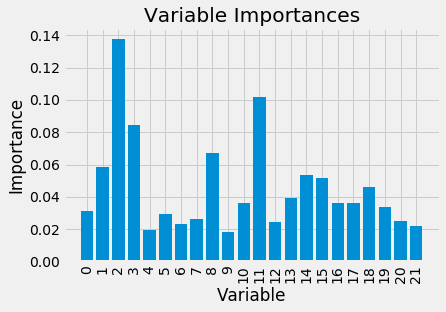

In [26]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, list(PCA_x_train.columns), rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [28]:
%%time
## Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
#tree = forest.estimators_[5]
# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = list(train_x.columns), rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file //DO NOT DO THIS HOLY CRAP
#graph.write_png('tree.png')
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(PCA_x_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]

CPU times: user 5.91 s, sys: 0 ns, total: 5.91 s
Wall time: 6.01 s


In [30]:
%%time
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(PCA_x_train.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

CPU times: user 547 ms, sys: 297 ms, total: 844 ms
Wall time: 6.4 s
